In [1]:
!nvidia-smi

Wed Mar 24 08:59:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -qq transformers==4.4.2

In [4]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import re
import string
import nltk

from nltk.corpus import stopwords
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim, zeros
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval

In [5]:
nltk.download('stopwords')

stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # for testing

In [7]:
df = pd.read_csv("drive/My Drive/UST/6000H/ml4nlp-argimpact/train.csv")
valid = pd.read_csv("drive/My Drive/UST/6000H/ml4nlp-argimpact/valid.csv")

In [8]:
df.head()

,id,text,context,stance_label,impact_label
0,train_0,All adoption agencies conduct interviews and h...,['A license should be required in order to hav...,"['NULL', 'OPPOSE', 'OPPOSE', 'SUPPORT']",MEDIUM_IMPACT
1,train_1,Genetically modified crops need fewer scarce r...,['The sale of genetically modified food should...,"['NULL', 'OPPOSE', 'SUPPORT']",IMPACTFUL
2,train_2,Some of Antifa's actions may be morally questi...,['Democrats should not cooperate with Donald T...,"['NULL', 'OPPOSE', 'SUPPORT', 'OPPOSE', 'SUPPO...",MEDIUM_IMPACT
3,train_3,Most pet lovers eat animals.,['People should donate to organisations that s...,"['NULL', 'OPPOSE', 'OPPOSE', 'OPPOSE', 'SUPPORT']",MEDIUM_IMPACT
4,train_4,Biologically-driven reproductive desires are c...,['Gender (the concept of masculinity and femin...,"['NULL', 'SUPPORT', 'SUPPORT', 'OPPOSE', 'SUPP...",IMPACTFUL


In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
df = df.append(valid)

In [12]:
df['text'] = df.apply(lambda row: (' '.join(eval(row.context)) + ' ' + row.text), axis=1)
# df['text'] = df.apply(lambda row: (eval(row.context)[-1] + ' ' + row.text), axis=1)

In [13]:
df.text.iloc[0]

"A license should be required in order to have a child (procreate). It is impossible to design a test that accurately assesses the ability to be a parent. What constitutes ideal or adequate parenthood is at least partly a cultural value judgement that isn't meant to reflect a scientific standard (but rather a cultural one). All adoption agencies conduct interviews and home-studies, which are partly meant to be educative experiences for prospective parents. When such interviews are conducted in the licensing process, parents will have an opportunity to learn more about parenting."

In [14]:
df = df[['text', 'impact_label']]

In [15]:
def remove_stopwords(row):
    return ' '.join([word for word in row.text.split() if word not in stopwords])

In [16]:
df['text'] = df.apply(remove_stopwords, axis=1)

In [17]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=520, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


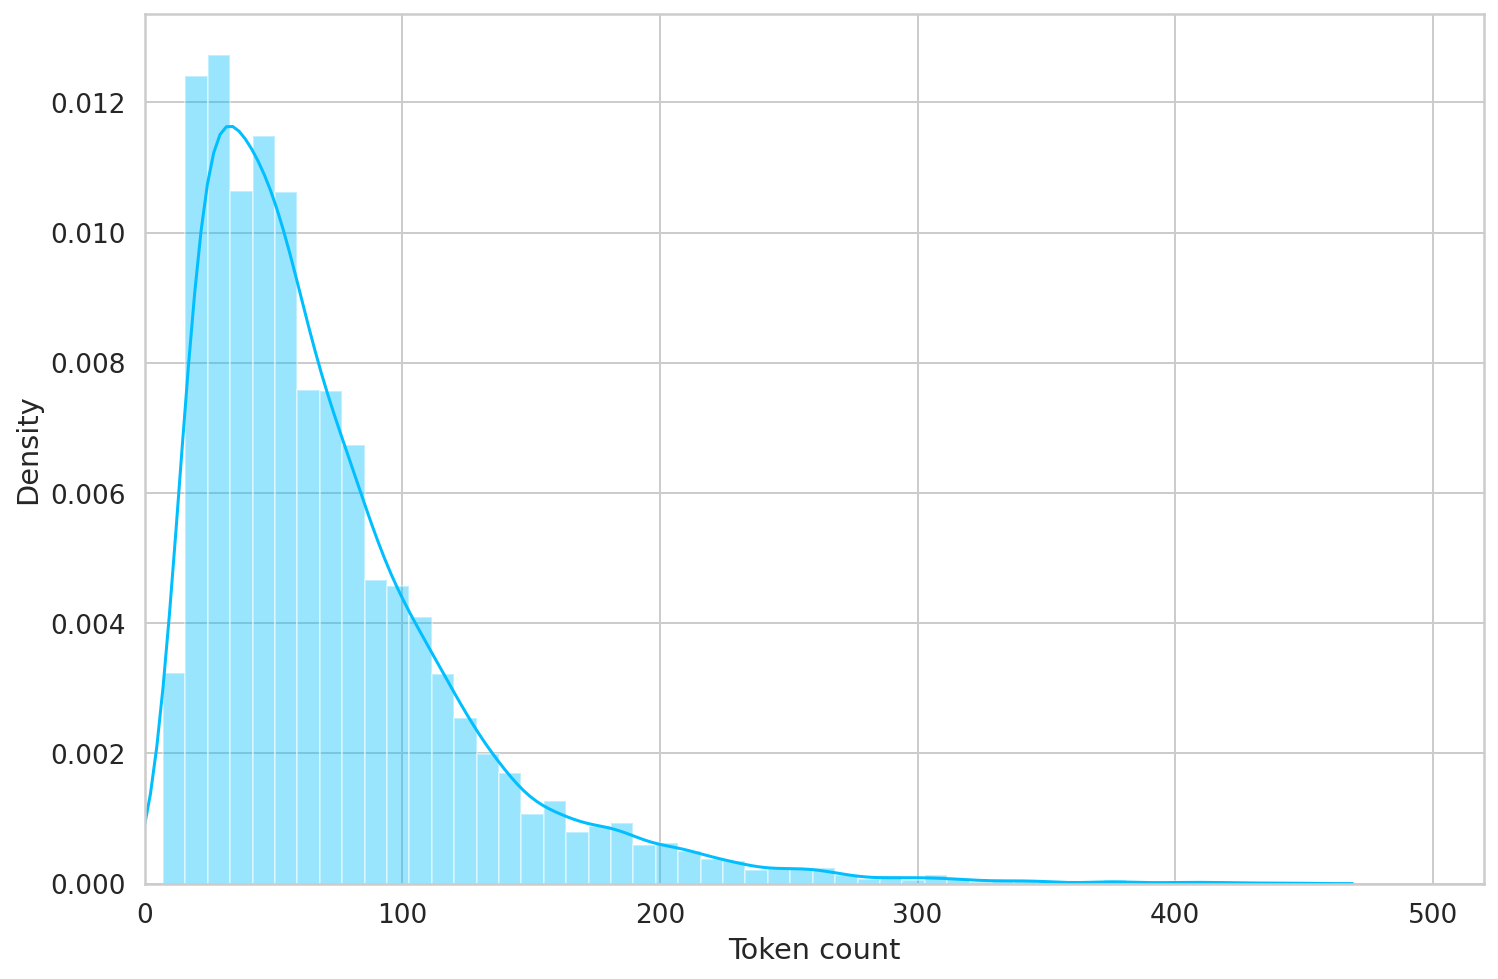

In [18]:
sns.distplot(token_lens)
plt.xlim([0, 520]);
plt.xlabel('Token count');

In [19]:
MAX_LEN = 512

In [20]:
class ArgumentDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [21]:
# df_train2, df_test = train_test_split(df_test, test_size=0.2, random_state=RANDOM_SEED)

In [22]:
# df = df.append(df_train2[['emotion', 'text']])

In [23]:
# del df_train2

In [24]:
class_names = df.impact_label.unique().tolist()

In [25]:
df['impact_label'] = df.impact_label.map({"NOT_IMPACTFUL": 0, "MEDIUM_IMPACT": 1, "IMPACTFUL": 2})

In [26]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

In [27]:
df_test = pd.read_csv("drive/My Drive/UST/6000H/ml4nlp-argimpact/test.csv")

In [28]:
df_test['text'] = df_test.apply(lambda row: ('. '.join(eval(row.context)) + ' ' + eval(row.text)[0]), axis=1)

In [29]:
df_test['text'] = df_test.apply(remove_stopwords, axis=1)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((5650, 2), (628, 2), (1108, 5))

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArgumentDataset(
    texts=df.text.to_numpy(),
    targets=df.impact_label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [32]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4])


In [35]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
class ArgumentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(ArgumentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )

    output = self.drop(pooled_output)
    return self.out(output)

In [37]:
model = ArgumentClassifier(len(class_names))
model = model.to(device)

In [38]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [39]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'drive/My Drive/UST/6000H/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.9106286541312955 accuracy 0.6007079646017699
Val   loss 0.8544599945378152 accuracy 0.5764331210191083

Epoch 2/10
----------
Train loss 0.832120489468831 accuracy 0.6343362831858407
Val   loss 0.856010956938859 accuracy 0.606687898089172

Epoch 3/10
----------
Train loss 0.7907461167668419 accuracy 0.6658407079646018
Val   loss 0.8999627439459418 accuracy 0.5796178343949044

Epoch 4/10
----------
Train loss 0.7313193592169736 accuracy 0.6991150442477876
Val   loss 1.0309500293272316 accuracy 0.5589171974522293

Epoch 5/10
----------


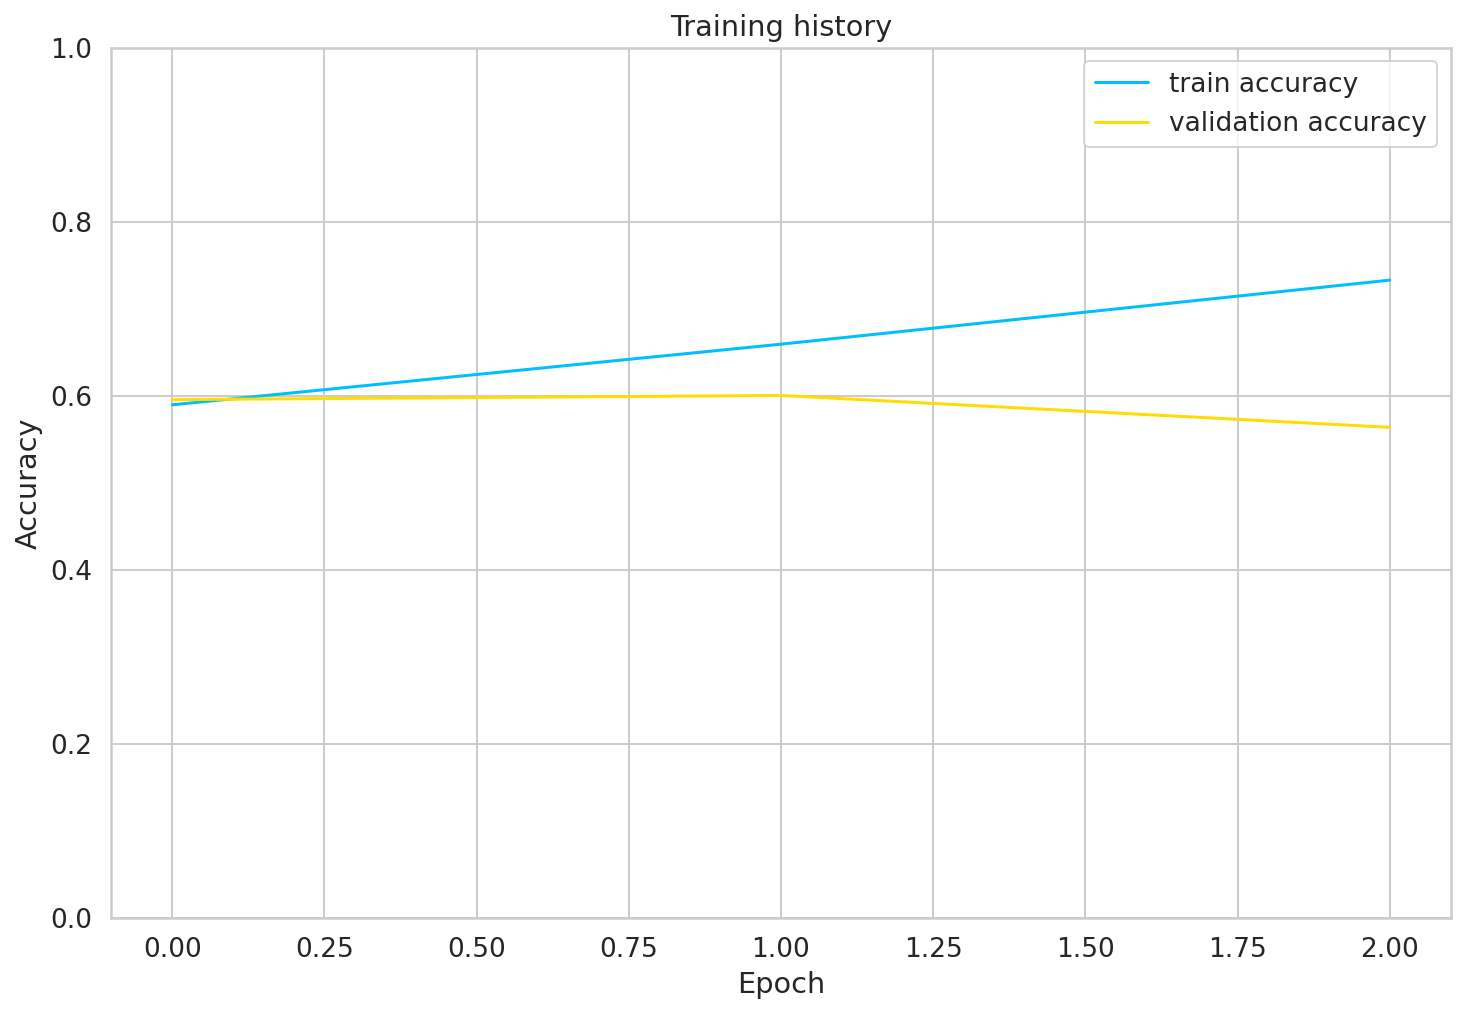

In [37]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [38]:
model.load_state_dict(torch.load('drive/My Drive/UST/6000H/best_model_state.bin'))

<All keys matched successfully>

In [39]:
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
)

print(val_acc)

tensor(0.6003, device='cuda:0', dtype=torch.float64)


In [75]:
df_test

,id,text,context,stance_label,impact_label
0,test_0,The possible scientific advancements outweigh ...,"['Cloning animals is ethical', 'The possible s...","['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN
1,test_1,Improvements in communication technology incre...,"['Europeans, defined as citizens of what today...","['NULL', 'OPPOSE', 'SUPPORT', 'OPPOSE']",UNKNOWN
2,test_2,Polygamy can have positive consequences for so...,"['Polygamy should be legal', 'Polygamy can hav...","['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN
3,test_3,Internet companies are wrong in denying servic...,['Internet companies are wrong in denying serv...,"['NULL', 'OPPOSE']",UNKNOWN
4,test_4,The world will have better politics and govern...,['Abolishing all aspects of privacy (through a...,"['NULL', 'SUPPORT', 'SUPPORT']",UNKNOWN
...,...,...,...,...,...
1103,test_1103,While it might appear as if referendums streng...,['Democracies should not use referendums for p...,"['NULL', 'OPPOSE', 'OPPOSE', 'SUPPORT', 'SUPPO...",UNKNOWN
1104,test_1104,If they do not pull the lever they are no murd...,"['The right thing to do is to pull the lever, ...","['NULL', 'OPPOSE', 'SUPPORT', 'SUPPORT']",UNKNOWN
1105,test_1105,Not everyone considers illegal downloading to ...,"['It is unethical to use ad-blockers.', 'There...","['NULL', 'OPPOSE', 'OPPOSE', 'OPPOSE', 'SUPPORT']",UNKNOWN
1106,test_1106,Torture can help force prisoners to reveal inf...,['Physical torture of prisoners is an acceptab...,"['NULL', 'SUPPORT', 'OPPOSE']",UNKNOWN


In [ ]:
# test_acc, _ = eval_model(
#   model,
#   test_data_loader,
#   loss_fn,
#   device,
#   len(df_test)
# )

# test_acc.item()

In [ ]:
import torch.nn.functional as F

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader,
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names, labels=[0, 1, 2]))

              precision    recall  f1-score   support

    negative       0.58      0.69      0.63       799
     neutral       0.93      0.83      0.88      5121
    positive       0.50      0.82      0.62       615

    accuracy                           0.81      6535
   macro avg       0.67      0.78      0.71      6535
weighted avg       0.85      0.81      0.83      6535



In [76]:
def get_prediction(row):
    text = row.text
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    return prediction.data.tolist()[0]

In [77]:
df_test["pred"] = df_test.apply(get_prediction, axis=1)

In [81]:
df_test[['id', 'pred']].to_csv('drive/My Drive/UST/6000H/submission.csv', index=False)